In [ ]:
!pip install tensorflow-gpu

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
!git clone https://github.com/tensorflow/models.git

In [ ]:
cd /content/models/research

/content/models/research


In [ ]:
 !protoc object_detection/protos/*.proto --python_out=.

In [ ]:
!git clone https://github.com/cocodataset/cocoapi.git


In [ ]:
cd cocoapi/PythonAPI

/content/models/research/cocoapi/PythonAPI


In [ ]:
!make

In [ ]:
cp -r pycocotools /content/models/research

In [ ]:
cd ..

/content/models/research/cocoapi


In [ ]:
cd ..

/content/models/research


In [ ]:
cp object_detection/packages/tf2/setup.py .

In [ ]:
!python -m pip install .

In [ ]:
!python object_detection/builders/model_builder_tf2_test.py

In [ ]:
cd /content/training_demo/pre-trained-models

/content/training_demo/pre-trained-models


In [ ]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8.tar.gz

In [ ]:
!tar -xvf mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8.tar.gz

In [ ]:
cd /content/training_demo

/content/training_demo


In [ ]:
# Create train data:
!python generate_tfrecord.py -x /content/training_demo/images/train -l /content/training_demo/annotations/label_map.pbtxt -o /content/training_demo/annotations/train.record

# Create test data:
!python generate_tfrecord.py -x /content/training_demo/images/test -l /content/training_demo/annotations/label_map.pbtxt -o /content/training_demo/annotations/test.record

Successfully created the TFRecord file: /content/training_demo/annotations/train.record
Successfully created the TFRecord file: /content/training_demo/annotations/test.record


In [ ]:
pwd

'/content/training_demo'

In [ ]:
#!python model_main_tf2.py --alsologtostderr --model_dir=/content/training_demo/models/my_SSD --pipeline_config_path=/content/training_demo/models/my_SSD/pipeline.config --sample_1_of_n_eval_on_train_examples=25 --num_eval_steps=100 --sample_1_of_n_eval_examples=1 
!python model_main_tf2.py --model_dir=/content/training_demo/models/my_maskRCNN --pipeline_config_path=/content/training_demo/models/my_maskRCNN/pipeline.config 

2021-05-08 03:24:17.353082: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-05-08 03:24:21.595733: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-05-08 03:24:21.602113: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-05-08 03:24:21.644748: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-05-08 03:24:21.645425: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-05-08 03:24:21.645481: I tensorflow/stream_executor/platform/default/dso_loade

In [ ]:
#to print mAP and avg Recall
#!python model_main_tf2.py --model_dir=/content/training_demo/models/my_maskRCNN --pipeline_config_path=/content/training_demo/models/my_maskRCNN/pipeline.config --checkpoint_dir=/content/training_demo/models/my_maskRCNN

In [ ]:
#!python model_main_tf2.py --model_dir=/content/training_demo/models/my_SSD --pipeline_config_path=/content/training_demo/models/my_SSD/pipeline.config

In [ ]:
!python exporter_main_v2.py --input_type image_tensor --pipeline_config_path /content/training_demo/models/my_maskRCNN/pipeline.config --trained_checkpoint_dir /content/training_demo/models/my_maskRCNN --output_directory /content/training_demo/exported_models/my_model

Loading model...Done! Took 31.386258125305176 seconds
Running inference for /content/training_demo/images/train/bike_right_6_1615190828477_6045da6eb0cfb3579c4177ff.jpg... WARNING:tensorflow:10 out of the last 10 calls to <function recreate_function.<locals>.restored_function_body at 0x7fe4c8294b00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
Done


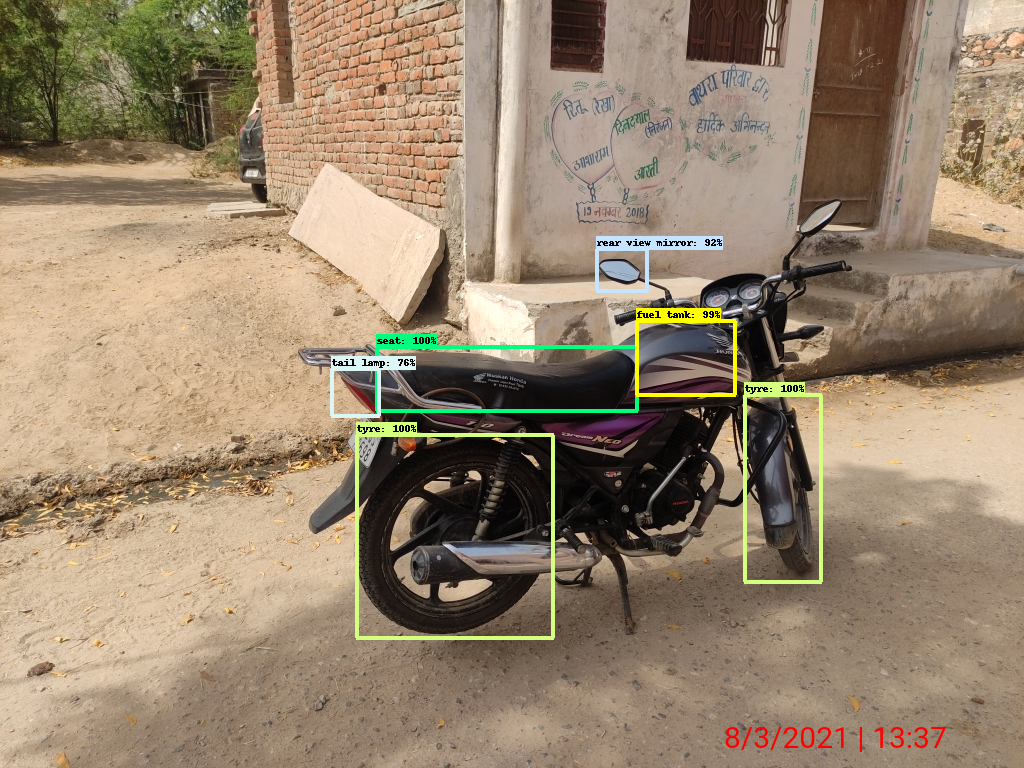

In [ ]:
"""
Object Detection (On Image) From TF2 Saved Model
=====================================
"""

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf
import cv2
import argparse
from google.colab.patches import cv2_imshow

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# PROVIDE PATH TO IMAGE DIRECTORY
IMAGE_PATHS = '/content/training_demo/images/train/bike_right_6_1615190828477_6045da6eb0cfb3579c4177ff.jpg'

# PROVIDE PATH TO MODEL DIRECTORY
PATH_TO_MODEL_DIR = '/content/training_demo/exported_models/my_model'

# PROVIDE PATH TO LABEL MAP
PATH_TO_LABELS = '/content/training_demo/annotations/label_map.pbtxt'

# PROVIDE THE MINIMUM CONFIDENCE THRESHOLD
MIN_CONF_THRESH = float(0.7)

# LOAD THE MODEL

import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# LOAD SAVED MODEL AND BUILD DETECTION FUNCTION
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

# LOAD LABEL MAP DATA FOR PLOTTING

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.
    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.
    Args:
      path: the file path to the image
    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))




print('Running inference for {}... '.format(IMAGE_PATHS), end='')

image = cv2.imread(IMAGE_PATHS)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_expanded = np.expand_dims(image_rgb, axis=0)

# The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
input_tensor = tf.convert_to_tensor(image)
# The model expects a batch of images, so add an axis with `tf.newaxis`.
input_tensor = input_tensor[tf.newaxis, ...]

# input_tensor = np.expand_dims(image_np, 0)
detections = detect_fn(input_tensor)

# All outputs are batches tensors.
# Convert to numpy arrays, and take index [0] to remove the batch dimension.
# We're only interested in the first num_detections.
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
               for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_with_detections = image.copy()

# SET MIN_SCORE_THRESH BASED ON YOU MINIMUM THRESHOLD FOR DETECTIONS
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=0.7,
      agnostic_mode=False)

print('Done')
# DISPLAYS OUTPUT IMAGE
cv2_imshow(image_with_detections)
# CLOSES WINDOW ONCE KEY IS PRESSED